# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernible landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [1]:
from torchvision import datasets, models
import torchvision.transforms as transforms
import torch
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import os


torch.backends.cudnn.benchmark = True
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

In [2]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
num_workers = 4    # number of subprocesses to use for data loading
batch_size = 64    # how many samples per batch to load
valid_size = 0.2   # percentage of training set to use as validation

# define training and test data directories
data_dir = './landmark_images/'
traindir = data_dir + 'train'
testdir = data_dir + 'test'

# # convert data to a normalized torch.FloatTensor
image_transforms = transforms.Compose([transforms.Resize(size=224),
                                       transforms.CenterCrop(size=224),
                                       transforms.RandomRotation(20),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])
                                      ])


train_data = datasets.ImageFolder(traindir, transform=image_transforms)
test_data = datasets.ImageFolder(testdir, transform=image_transforms)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

loaders_scratch = {'train': torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                                        sampler=train_sampler, num_workers=num_workers,
                                                       pin_memory=True),
                   'valid': torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                                        sampler=train_sampler, num_workers=num_workers,
                                                       pin_memory=True),
                   'test': torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                                       num_workers=num_workers, pin_memory=True)}

# prepare data loaders (combine dataset and sampler)
train_loader = loaders_scratch['train']
valid_loader = loaders_scratch['valid']
test_loader = loaders_scratch['test']

num_classes = len(train_data.classes)
print(num_classes)

50


**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 

I resized all image to 224 pixel, center cropped, add randomly rotations for some degrees to avoid overfitting of the model.

I tried to approached the problem iteratively and starting with the examples from this project, I am working with (224, 224, 3) images, so the inputs are significantly bigger than the labs (28, 28, 1) for Mnist and (32x32x3) for CIFAR.
I've also realized that the most of the pre-trained models require the input to be 224x224 pixel images. Also, I'll need to match the normalization used when the models were trained. Each color channel has to normalized separately, the means are [0.485, 0.456, 0.406] and the standard deviations are [0.229, 0.224, 0.225].

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

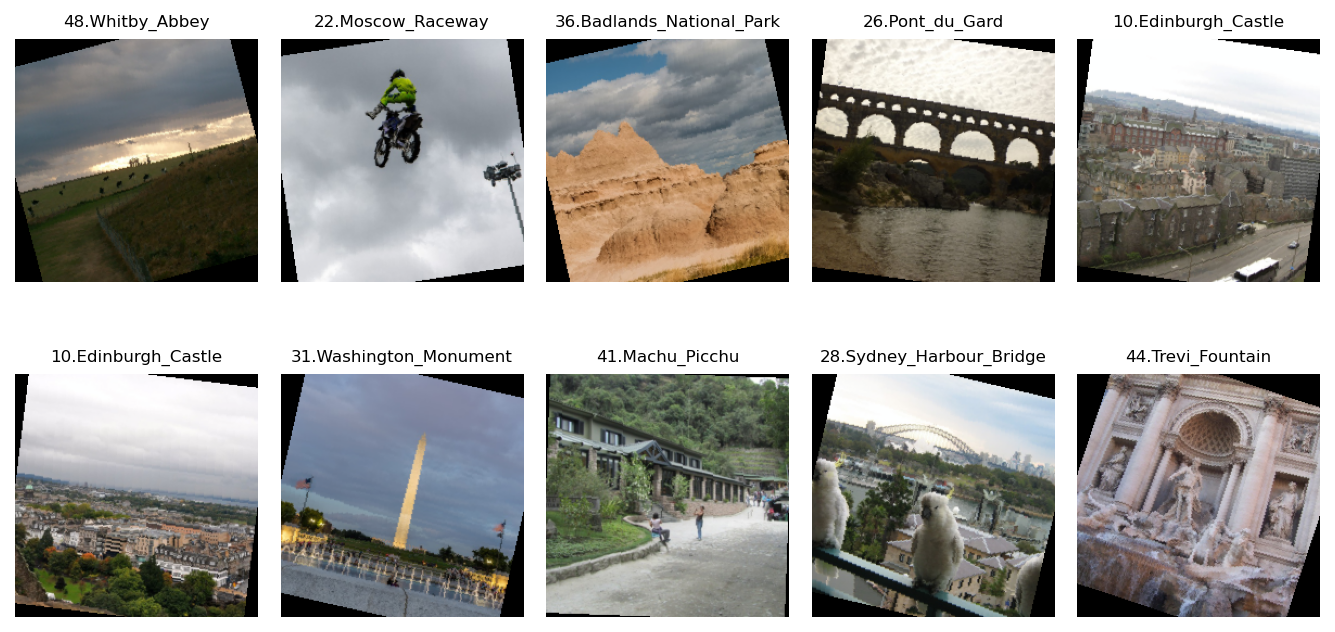

In [3]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img.numpy().transpose(1, 2, 0)  # PIL images have channel last
    mean = [0.485, 0.456, 0.406]
    stdd = [0.229, 0.224, 0.225]
    img = (img * stdd + mean).clip(0, 1)
    return img

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

plt.rcParams['figure.dpi'] = 150

# Show a grid of example images    
fig, axes = plt.subplots(2, 5, figsize=(9, 5))
axes = axes.flatten()
for ax, image, index in zip(axes, images, labels):
    ax.imshow(imshow(image))
    ax.set_axis_off()
    ax.set_title(train_data.classes[index], fontsize=8)
    fig.subplots_adjust(wspace=0.02, hspace=0)
    fig.tight_layout()

### Initialize use_cuda variable

In [4]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [5]:
## TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    model = optim.AdamW(model.parameters(), lr=0.01)
    
    return model

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [6]:
# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class 
    def __init__(self):
        super(Net, self).__init__()
        
        print("create model ... ", end="")
        
        ## Define layers of a CNN
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer
        self.fc1 = nn.Linear(64 * 28 * 28, 128)
        # linear layer (500 -> 50)
        self.fc2 = nn.Linear(128, num_classes)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)
        self.batch_norm = nn.BatchNorm1d(num_features=128)
        
        
    def forward(self, x):
        ## Define forward behavior
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(x.size(0), -1)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.batch_norm( self.fc1(x)) )
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()
print(model_scratch)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

create model ... Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=50, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  

The first layer in the CNN is a convolutional layer that takes (224, 224, 3) input size of 50 classes.

I'd like the new layer to have 16 filters, each with a height and width of 3. When performing the convolution, I'd like the filter to jump 1 pixel at a time.

    _nn.Conv2d(in_channels, out_channels, kernelsize, stride=1, padding=0)

I want this layer to have the same width and height as the input layer, so I will pad accordingly; Then, to construct this convolutional layer, I use the following line of code:

    self.conv2 = nn.Conv2d(3, 32, 3, padding=1)

I am adding a pool layer that takes a kernel_size and a stride after every convolution layer. This will down-sample the input's x-y dimensions, by a factor of 2:

    self.pool = nn.MaxPool2d(2,2)

I am adding a fully connected linear layer at the end to produce a 50-dim output. As well as a Dropout layer to avoid overfitting.

A forward pass would give the following structure:

    torch.Size([16, 3, 224, 224])

    torch.Size([16, 16, 112, 112])

    torch.Size([16, 32, 56, 56])

    torch.Size([16, 64, 28, 28])

    torch.Size([16, 50176])

    torch.Size([16, 500])

    torch.Size([16, 50])

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [7]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    
    # exist save-file, load save file
    if os.path.exists(save_path):
        print("load previous saved model ...")
        model.load_state_dict(torch.load(save_path))
        
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):

            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad(set_to_none=True)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.detach()*data.size(0)

            
            

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(valid_loader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss
            valid_loss += loss.detach()*data.size(0)

            
        # calculate average losses
        train_loss = train_loss/len(train_loader.sampler)
        valid_loss = valid_loss/len(valid_loader.sampler)
        
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss, end=""))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [8]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    if isinstance(m, nn.Conv2d):
        m.weight.data.normal_(0, 0.02)
        m.bias.data.zero_()
    elif isinstance(m, nn.Linear):
        m.weight.data.normal_(0, 0.02)
        m.bias.data.zero_()
    
    

#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(10, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

load previous saved model ...
Epoch: 1 	Training Loss: 2.569729 	Validation Loss: 2.100670
Validation loss decreased (inf --> 2.100670).  Saving model ...
Epoch: 2 	Training Loss: 2.365887 	Validation Loss: 2.027413
Validation loss decreased (2.100670 --> 2.027413).  Saving model ...
Epoch: 3 	Training Loss: 2.241768 	Validation Loss: 1.826511
Validation loss decreased (2.027413 --> 1.826511).  Saving model ...
Epoch: 4 	Training Loss: 2.103884 	Validation Loss: 1.659331
Validation loss decreased (1.826511 --> 1.659331).  Saving model ...
Epoch: 5 	Training Loss: 1.985072 	Validation Loss: 1.512019
Validation loss decreased (1.659331 --> 1.512019).  Saving model ...
Epoch: 6 	Training Loss: 1.905725 	Validation Loss: 1.525671
Epoch: 7 	Training Loss: 1.817186 	Validation Loss: 1.337682
Validation loss decreased (1.512019 --> 1.337682).  Saving model ...
Epoch: 8 	Training Loss: 1.722563 	Validation Loss: 1.298211
Validation loss decreased (1.337682 --> 1.298211).  Saving model ...
Epoc

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [9]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 10
#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model 
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

load previous saved model ...
Epoch: 1 	Training Loss: 2.569074 	Validation Loss: 2.133349
Validation loss decreased (inf --> 2.133349).  Saving model ...
Epoch: 2 	Training Loss: 2.337926 	Validation Loss: 1.954307
Validation loss decreased (2.133349 --> 1.954307).  Saving model ...
Epoch: 3 	Training Loss: 2.189509 	Validation Loss: 1.836033
Validation loss decreased (1.954307 --> 1.836033).  Saving model ...
Epoch: 4 	Training Loss: 2.079099 	Validation Loss: 1.654004
Validation loss decreased (1.836033 --> 1.654004).  Saving model ...
Epoch: 5 	Training Loss: 1.995490 	Validation Loss: 1.567419
Validation loss decreased (1.654004 --> 1.567419).  Saving model ...
Epoch: 6 	Training Loss: 1.863627 	Validation Loss: 1.480632
Validation loss decreased (1.567419 --> 1.480632).  Saving model ...
Epoch: 7 	Training Loss: 1.782091 	Validation Loss: 1.303887
Validation loss decreased (1.480632 --> 1.303887).  Saving model ...
Epoch: 8 	Training Loss: 1.646969 	Validation Loss: 1.191111
Vali

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [10]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy -model_scratch.pt-
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.044593


Test Accuracy: 31% (399/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [11]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

loaders_transfer = loaders_scratch.copy()
# prepare data loaders (combine dataset and sampler)
train_loader = loaders_transfer['train']
valid_loader = loaders_transfer['valid']
test_loader = loaders_transfer['test']

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [12]:
## TODO: select loss function
criterion_transfer = nn.CrossEntropyLoss()

def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    model = optim.AdamW(model.parameters(), lr=0.01)
    return model

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [13]:
## TODO: Specify model architecture
#model_transfer =  models.vgg19(pretrained=True)
model_transfer =  models.alexnet(pretrained=True)

# this is needed for pre-trained networks
# freeze parameters so we don't backprop through them
for param in model_transfer.parameters():
    param.requires_grad = False

model_transfer.classifier[6] = nn.Linear(4096, num_classes, bias=True)
print(model_transfer)

#-#-# Do NOT modify the code below this line. #-#-#
if use_cuda:
    model_transfer = model_transfer.cuda()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  

I'll use a **alexnet** model from torchvision model archiv, which was already trained previously. The classifier part of the model is a single fully-connected layer:

        classifier[6]: (6): Linear(in_features=4096, out_features=1000, bias=True)

This layer was already trained on the ImageNet dataset, so it won't work for the landmark classification specific problem with different output size, means I need to replace the classifier (50 classes).

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [14]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'
model_transfer = train(10, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer),
                      criterion_transfer, use_cuda, 'model_transfer.pt')


#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

load previous saved model ...
Epoch: 1 	Training Loss: 4.195210 	Validation Loss: 1.586942
Validation loss decreased (inf --> 1.586942).  Saving model ...
Epoch: 2 	Training Loss: 3.176030 	Validation Loss: 1.186133
Validation loss decreased (1.586942 --> 1.186133).  Saving model ...
Epoch: 3 	Training Loss: 2.868873 	Validation Loss: 1.037404
Validation loss decreased (1.186133 --> 1.037404).  Saving model ...
Epoch: 4 	Training Loss: 2.673997 	Validation Loss: 0.943730
Validation loss decreased (1.037404 --> 0.943730).  Saving model ...
Epoch: 5 	Training Loss: 2.551795 	Validation Loss: 0.916311
Validation loss decreased (0.943730 --> 0.916311).  Saving model ...
Epoch: 6 	Training Loss: 2.399288 	Validation Loss: 0.908761
Validation loss decreased (0.916311 --> 0.908761).  Saving model ...
Epoch: 7 	Training Loss: 2.470517 	Validation Loss: 0.780295
Validation loss decreased (0.908761 --> 0.780295).  Saving model ...
Epoch: 8 	Training Loss: 2.410985 	Validation Loss: 0.814047
Epoc

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [15]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 8.819059


Test Accuracy: 64% (804/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [19]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    real_class = img_path.split('/')[-2]
    img_pil = Image.open( img_path ).convert('RGB')
    img_tensor = image_transforms( img_pil )[:3,:,:].unsqueeze(0)

    # move model inputs to cuda, if GPU available
    # Resize
    if use_cuda:
        img_tensor = img_tensor.view(1, 3, 224, 224).cuda()
    else:
        img_tensor = img_tensor.view(1, 3, 224, 224)
    
    # Set to evaluation
    with torch.no_grad():
        model_transfer.eval
        # Model outputs log probabilities
        out = model_transfer(img_tensor)
        ps = torch.exp(out)

        # Find the topk predictions
        topk, topclass = ps.topk(k, dim=1)

        # Extract the actual classes
        top_classes = [
            train_data.classes[class_] for class_ in topclass.cpu().numpy()[0]
        ]
        
        top_p = topk.cpu().numpy()[0]

        return top_classes


# test on a sample image testdir
predict_landmarks('landmark_images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

['38.Forth_Bridge',
 '09.Golden_Gate_Bridge',
 '03.Dead_Sea',
 '30.Brooklyn_Bridge',
 '21.Taj_Mahal']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

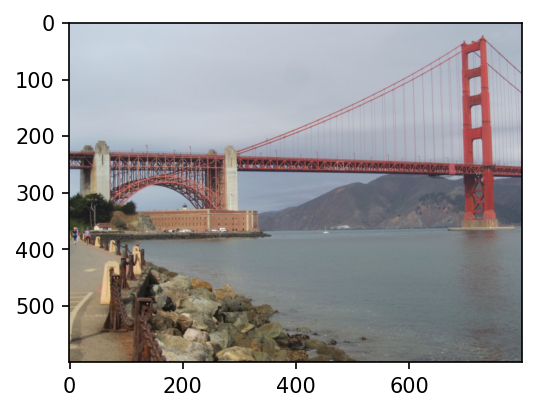

Is this pictuer of the
09.Golden_Gate_Bridge, 38.Forth_Bridge, 28.Sydney_Harbour_Bridge


In [20]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions
    img_pil = Image.open( img_path ).convert('RGB')
    img_tensor = image_transforms( img_pil )[:3,:,:].unsqueeze(0)
    plt.figure(figsize=(9, 3))
    ax = plt.subplot(1, 2, 1)
    ax.imshow(img_pil)
    plt.show()
    pred = [str(i) for i in predicted_landmarks]
    print('Is this pictuer of the\n'+ ", ".join(pred))


# test on a sample image
suggest_locations('landmark_images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

1. Increasing number of epoch might help.
2. Try out to expand or modify the classifier fully connected layers to train the net faster.
3. Expand training time.

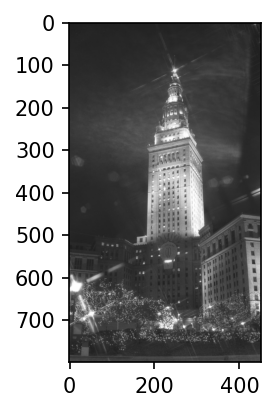

Is this pictuer of the
14.Terminal_Tower, 28.Sydney_Harbour_Bridge, 35.Monumento_a_la_Revolucion


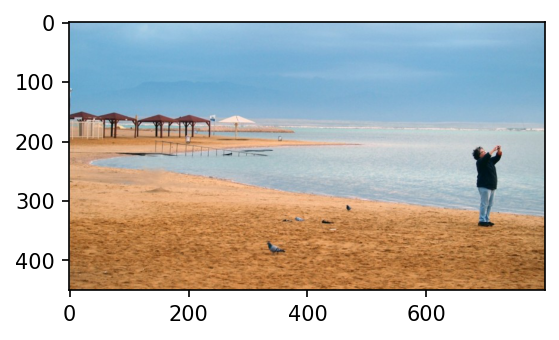

Is this pictuer of the
42.Death_Valley_National_Park, 18.Delicate_Arch, 03.Dead_Sea


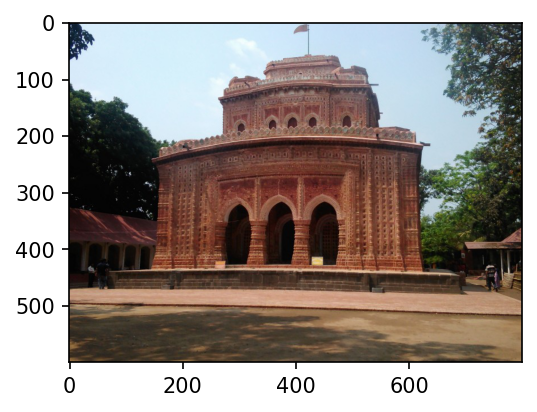

Is this pictuer of the
12.Kantanagar_Temple, 21.Taj_Mahal, 26.Pont_du_Gard


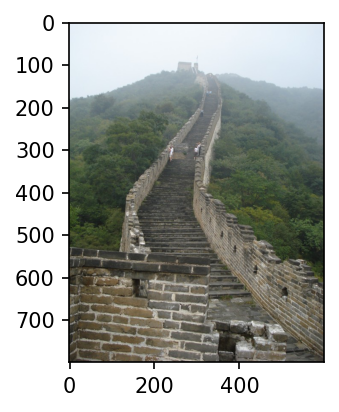

Is this pictuer of the
46.Great_Wall_of_China, 41.Machu_Picchu, 16.Eiffel_Tower


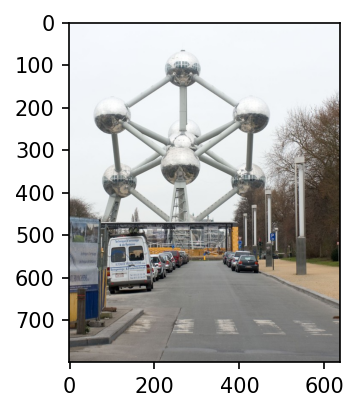

Is this pictuer of the
37.Atomium, 16.Eiffel_Tower, 42.Death_Valley_National_Park


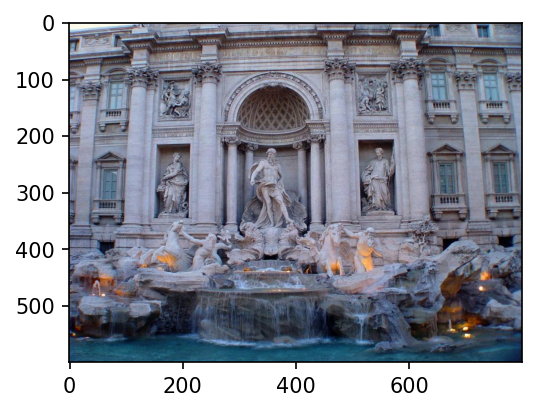

Is this pictuer of the
44.Trevi_Fountain, 32.Hanging_Temple, 40.Stockholm_City_Hall


In [23]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.

suggest_locations('landmark_images/test/14.Terminal_Tower/7dffcaf9f66d3fc2.jpg')
suggest_locations('landmark_images/test/03.Dead_Sea/3a690b5b9fdf2400.jpg')
suggest_locations('landmark_images/test/12.Kantanagar_Temple/68a74d455c243ca9.jpg')
suggest_locations('landmark_images/test/46.Great_Wall_of_China/41b8bfb5a88325aa.jpg')
suggest_locations('landmark_images/test/37.Atomium/0bac17c7a2d6594e.jpg')
suggest_locations('landmark_images/test/44.Trevi_Fountain/560c009f91c5c909.jpg')